# Section B: From-Scratch Implementations

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

In [2]:
df = pd.read_csv('Titanic-Dataset.csv')
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)
X = df.drop('Survived', axis=1).values
y = df['Survived'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)

### Logistic Regression Variants

In [3]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=5000, regularization=None, C=1.0):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.C = C
        self.weights = None
        self.bias = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        G_w = np.zeros(n_features)
        G_b = 0
        epsilon = 1e-8

        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            if self.regularization == 'l1':
                dw += (1 / self.C) * np.sign(self.weights)
            elif self.regularization == 'l2':
                dw += (2 / self.C) * self.weights

            G_w += dw**2
            G_b += db**2

            self.weights -= (self.learning_rate / (np.sqrt(G_w) + epsilon)) * dw
            self.bias -= (self.learning_rate / (np.sqrt(G_b) + epsilon)) * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        y_predicted_proba = self.predict_proba(X)
        y_predicted = [1 if i > threshold else 0 for i in y_predicted_proba]
        return np.array(y_predicted)

### Ensemble Methods

#### Decision Tree

In [4]:
class DecisionTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth

    def _gini(self, y):
        m = len(y)
        if m == 0:
            return 0
        return 1.0 - sum([(np.sum(y == c) / m) ** 2 for c in np.unique(y)])

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None

        best_gini = self._gini(y)
        best_idx, best_thr = None, None

        for idx in range(n):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            for i in range(1, m):
                y_left, y_right = classes[:i], classes[i:]
                gini_left, gini_right = self._gini(y_left), self._gini(y_right)
                gini = (i * gini_left + (m - i) * gini_right) / m
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2

        return best_idx, best_thr

    def fit(self, X, y, depth=0):
        self.n_classes_ = len(np.unique(y))
        if depth >= self.max_depth or self.n_classes_ == 1:
            self.leaf_value_ = self._most_common_label(y)
            return

        best_idx, best_thr = self._best_split(X, y)
        if best_idx is not None:
            self.feature_index_ = best_idx
            self.threshold_ = best_thr
            indices_left = X[:, best_idx] < best_thr
            X_left, y_left = X[indices_left], y[indices_left]
            X_right, y_right = X[~indices_left], y[~indices_left]
            self.left_ = DecisionTree(self.max_depth)
            self.left_.fit(X_left, y_left, depth + 1)
            self.right_ = DecisionTree(self.max_depth)
            self.right_.fit(X_right, y_right, depth + 1)
        else:
            self.leaf_value_ = self._most_common_label(y)

    def predict(self, X):
        if hasattr(self, 'leaf_value_'):
            return np.full(X.shape[0], self.leaf_value_)

        indices_left = X[:, self.feature_index_] < self.threshold_
        predictions = np.zeros(X.shape[0])
        predictions[indices_left] = self.left_.predict(X[indices_left])
        predictions[~indices_left] = self.right_.predict(X[~indices_left])
        return predictions

    def _most_common_label(self, y):
        if len(y) == 0:
            return 0
        return np.bincount(y.astype(int)).argmax()

#### Decision Stump

In [5]:
class DecisionStump:
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions

    def fit(self, X, y, w):
        n_samples, n_features = X.shape
        min_error = float('inf')

        for feature_i in range(n_features):
            X_column = X[:, feature_i]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                p = 1
                predictions = np.ones(n_samples)
                predictions[X_column < threshold] = -1

                misclassified = w[y != predictions]
                error = sum(misclassified)

                if error > 0.5:
                    error = 1 - error
                    p = -1

                if error < min_error:
                    self.polarity = p
                    self.threshold = threshold
                    self.feature_idx = feature_i
                    min_error = error

#### Simple Bagging

In [6]:
class SimpleBagging:
    def __init__(self, n_estimators=100, max_depth=3):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.estimators = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample, y_sample = X[indices], y[indices]
            estimator = DecisionTree(max_depth=self.max_depth)
            estimator.fit(X_sample, y_sample)
            self.estimators.append(estimator)

    def predict(self, X):
        predictions = np.array([estimator.predict(X) for estimator in self.estimators])
        return np.round(np.mean(predictions, axis=0)).astype(int)

#### Simple Boosting (AdaBoost)

In [7]:
class AdaBoost:
    def __init__(self, n_estimators=200):
        self.n_estimators = n_estimators
        self.estimators = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        w = np.full(n_samples, (1 / n_samples))

        for _ in range(self.n_estimators):
            clf = DecisionStump()
            clf.fit(X, y, w)

            predictions = clf.predict(X)
            misclassified = w[y != predictions]
            error = sum(misclassified)

            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - error + EPS) / (error + EPS))

            w *= np.exp(-clf.alpha * y * predictions)
            w /= np.sum(w)

            self.estimators.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.estimators]
        y_pred = np.sum(clf_preds, axis=0)
        return np.sign(y_pred)

### Evaluation Metrics

In [8]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

def print_metrics(y_true, y_pred, y_pred_proba, model_name):
    print(f'--- {model_name} ---')
    print(f'Accuracy: {accuracy_score(y_true, y_pred):.4f}')
    print(f'Precision: {precision_score(y_true, y_pred):.4f}')
    print(f'Recall: {recall_score(y_true, y_pred):.4f}')
    print(f'F1 Score: {f1_score(y_true, y_pred):.4f}')
    print(f'AUC: {roc_auc_score(y_true, y_pred_proba):.4f}')
    plot_confusion_matrix(y_true, y_pred, f'{model_name} - Confusion Matrix')
    plot_roc_curve(y_true, y_pred_proba, f'{model_name} - ROC Curve')
    print('')

### Evaluation

--- Standard Logistic Regression ---
Accuracy: 0.7654
Precision: 0.8000
Recall: 0.5217
F1 Score: 0.6316
AUC: 0.8161


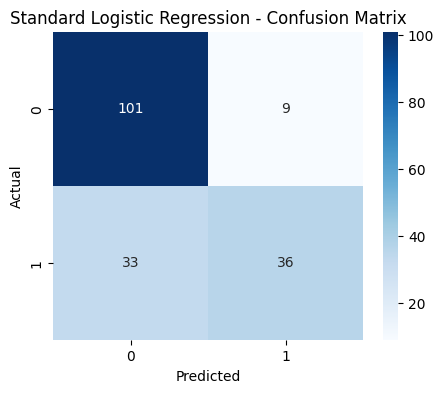

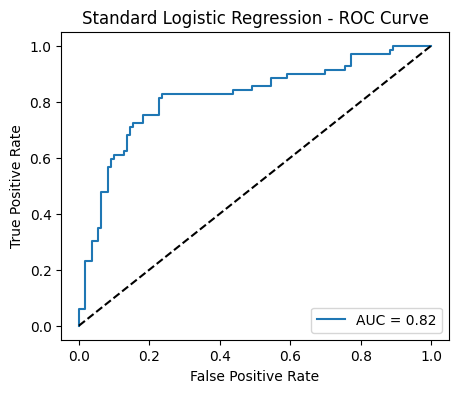


--- L1 Logistic Regression ---
Accuracy: 0.7709
Precision: 0.8684
Recall: 0.4783
F1 Score: 0.6168
AUC: 0.8237


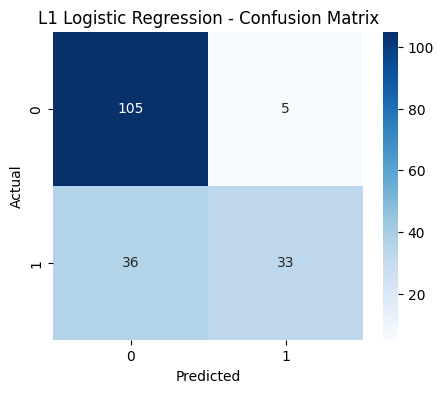

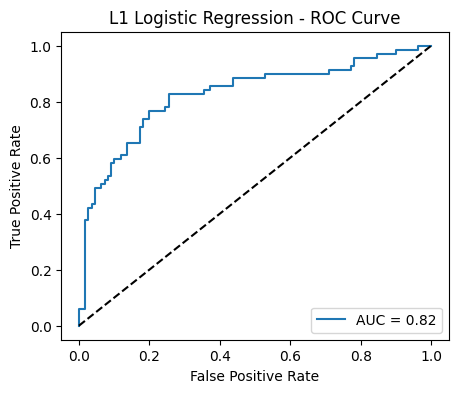


--- L2 Logistic Regression ---
Accuracy: 0.6257
Precision: 0.5455
Recall: 0.1739
F1 Score: 0.2637
AUC: 0.6609


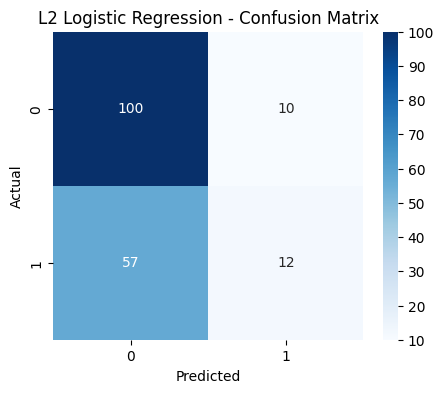

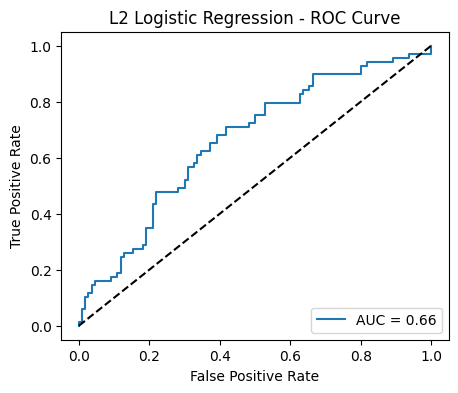


--- Simple Bagging ---
Accuracy: 0.6145
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC: 0.5000


c:\Users\Sahas Induwara\.conda\envs\foml\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


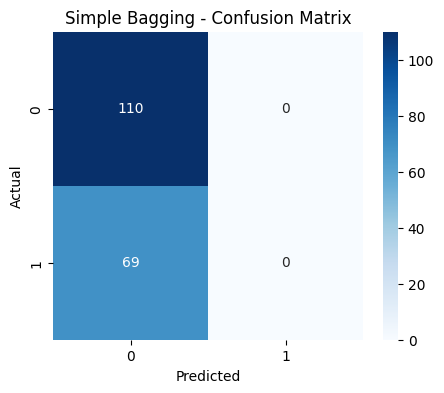

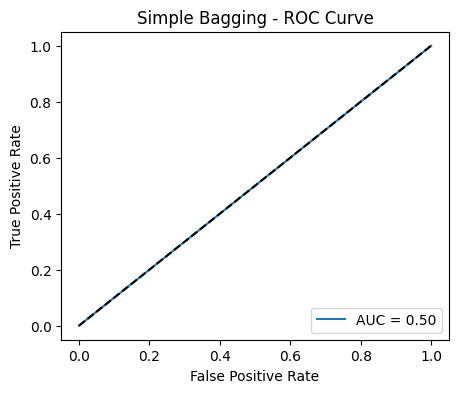


--- Simple Boosting (AdaBoost) ---
Accuracy: 0.6145
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC: 0.5000


c:\Users\Sahas Induwara\.conda\envs\foml\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


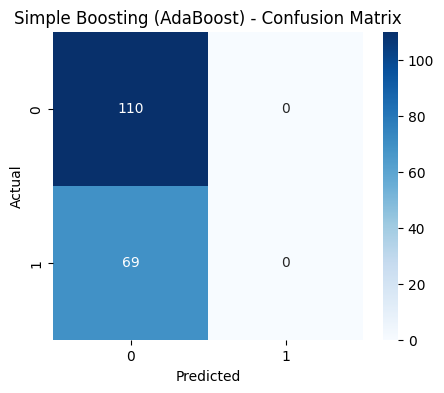

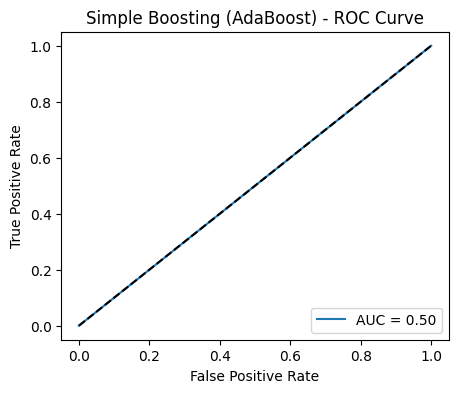

In [9]:
lr_no_reg = LogisticRegression()
lr_no_reg.fit(X_train, y_train)
y_pred_no_reg = lr_no_reg.predict(X_test)
print_metrics(y_test, y_pred_no_reg, lr_no_reg.predict_proba(X_test), 'Standard Logistic Regression')

lr_l1 = LogisticRegression(regularization='l1', C=100.0)
lr_l1.fit(X_train, y_train)
y_pred_l1 = lr_l1.predict(X_test)
print_metrics(y_test, y_pred_l1, lr_l1.predict_proba(X_test), 'L1 Logistic Regression')

lr_l2 = LogisticRegression(regularization='l2', C=0.1)
lr_l2.fit(X_train, y_train)
y_pred_l2 = lr_l2.predict(X_test)
print_metrics(y_test, y_pred_l2, lr_l2.predict_proba(X_test), 'L2 Logistic Regression')

bagging = SimpleBagging()
bagging.fit(X_train, y_train)
y_pred_bagging = bagging.predict(X_test)
print_metrics(y_test, y_pred_bagging, y_pred_bagging, 'Simple Bagging')

y_train_boost = np.where(y_train == 0, -1, 1)
adaboost = AdaBoost()
adaboost.fit(X_train, y_train_boost)
y_pred_adaboost = adaboost.predict(X_test)
y_pred_adaboost = np.where(y_pred_adaboost == -1, 0, 1)
print_metrics(y_test, y_pred_adaboost, y_pred_adaboost, 'Simple Boosting (AdaBoost)')